# Linear Mixed Models for ERP Components (Demo)

This notebook illustrates how to fit linear mixed models (LMMs) for ERP amplitudes across alignment conditions, with random effects for participant (and optionally electrode). It reuses the P300/N400/P600/FRN component windows and electrodes. If real evoked data are available in ./preprocessed, they will be loaded; otherwise, synthetic data are generated for demonstration.

In [7]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import mne
from scipy.stats import shapiro, levene, kruskal
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
import warnings
import os
warnings.filterwarnings('ignore')

# Optional: pingouin for Bayes factors
try:
    import pingouin as pg
    PG_AVAILABLE = True
except ImportError:
    PG_AVAILABLE = False

# Optional: arviz for Bayesian modeling
try:
    import arviz as az
    BAYES_AVAILABLE = True
except ImportError:
    BAYES_AVAILABLE = False
    print("⚠️  arviz not installed - skipping Bayesian visualization")

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")
sns.set_palette("Set2")

print("="*100)
print("LINEAR MIXED MODELS FOR ERP COMPONENTS")
print("="*100)
print("\n✓ Libraries loaded successfully")
print(f"Pingouin available: {PG_AVAILABLE}")
print(f"ArviZ available: {BAYES_AVAILABLE}")

LINEAR MIXED MODELS FOR ERP COMPONENTS

✓ Libraries loaded successfully
Pingouin available: True
ArviZ available: True


In [16]:
# Load evoked data (fallback to synthetic if unavailable)
preprocessed_dir = Path('./preprocessed')
conditions = ['high', 'medium', 'low']
condition_labels = {'high': 'High', 'medium': 'Medium', 'low': 'Low'}

component_specs = {
    'P300': {'tmin': 0.300, 'tmax': 0.500, 'electrodes': ['Cz', 'CPz', 'Pz']},
    'N400': {'tmin': 0.300, 'tmax': 0.500, 'electrodes': ['Cz', 'CPz', 'Pz', 'FCz']},
    'P600': {'tmin': 0.500, 'tmax': 0.800, 'electrodes': ['Pz', 'CPz', 'Cz']},
    'FRN':  {'tmin': 0.250, 'tmax': 0.350, 'electrodes': ['FCz', 'Cz']}
}

def load_evoked_data():
    erp_data = {c: {} for c in conditions}
    for condition in conditions:
        files = sorted(preprocessed_dir.glob(f'session_*-evoked-{condition}-ave.fif'))
        for sess_file in files:
            sess_id = int(sess_file.name.split('-')[0].replace('session_', ''))
            try:
                evoked = mne.read_evokeds(str(sess_file), verbose=False)[0]
                erp_data[condition][sess_id] = evoked
            except Exception:
                continue
    return erp_data

def extract_component_df(erp_data, comp_name):
    spec = component_specs[comp_name]
    records = []
    for condition in conditions:
        for sess_id, evoked in erp_data.get(condition, {}).items():
            times = evoked.times
            mask = (times >= spec['tmin']) & (times <= spec['tmax'])
            amps = []
            for ch_name in spec['electrodes']:
                if ch_name in evoked.ch_names:
                    ch_idx = evoked.ch_names.index(ch_name)
                    amps.append(np.mean(evoked.data[ch_idx, mask]) * 1e6)
            if len(amps) > 0:
                records.append({
                    'participant': sess_id,
                    'condition': condition_labels[condition],
                    'electrode_count': len(amps),
                    'component': comp_name,
                    'amplitude': np.mean(amps)
                })
    return pd.DataFrame(records)

erp_data = load_evoked_data()
n_sessions = sum(len(v) for v in erp_data.values())

if n_sessions == 0:
    print("⚠️  No evoked files found; generating synthetic data for demo")
    rng = np.random.default_rng(42)
    rows = []
    for comp_name, spec in component_specs.items():
        for subj in range(30):
            for condition in ['High', 'Medium', 'Low']:
                base = {'High': 3.0, 'Medium': 2.7, 'Low': 2.5}[condition] + rng.normal(0, 0.3)
                rows.append({
                    'participant': subj + 1,
                    'condition': condition,
                    'component': comp_name,
                    'electrode_count': len(spec['electrodes']),
                    'amplitude': base + rng.normal(0, 0.5)
                })
    df_all = pd.DataFrame(rows)
else:
    frames = [extract_component_df(erp_data, comp) for comp in ['P300', 'N400', 'P600', 'FRN']]
    df_all = pd.concat(frames, ignore_index=True)

df = df_all[df_all['component'] == 'P300'].copy()
print(f"✓ Data prepared: N={len(df)} rows for P300")
print(df.groupby('condition')['amplitude'].describe())

✓ Data prepared: N=48 rows for P300
           count      mean       std       min           25%           50%  \
condition                                                                    
High        17.0  0.019500  0.817288 -2.139182 -2.621104e-01 -2.678816e-11   
Low         15.0  0.391693  1.174697 -0.407549  2.914917e-11  3.841601e-02   
Medium      16.0 -0.204508  1.098389 -4.097835 -2.412416e-01  1.227823e-10   

                75%       max  
condition                      
High       0.345777  1.668320  
Low        0.232259  4.487141  
Medium     0.208280  0.650325  


In [9]:
# Assumption testing on P300 amplitudes
print("\n" + "="*100)
print("ASSUMPTION TESTING (P300)")
print("="*100)

high_vals = df[df['condition'] == 'High']['amplitude'].values
medium_vals = df[df['condition'] == 'Medium']['amplitude'].values
low_vals = df[df['condition'] == 'Low']['amplitude'].values

def safe_shapiro(vals):
    if len(vals) < 3:
        return np.nan, np.nan
    return shapiro(vals)

normality_tests = []
for cond, vals in [('High', high_vals), ('Medium', medium_vals), ('Low', low_vals)]:
    stat, p = safe_shapiro(vals)
    normality_tests.append({'Condition': cond, 'W': stat, 'p-value': p, 'Normal': p > 0.05 if not np.isnan(p) else False})
    print(f"{cond:8s}: W={stat:.4f} p={p:.4f} {'✓ NORMAL' if p>0.05 else '✗ NON-NORMAL'}")

levene_stat, levene_p = levene(high_vals, medium_vals, low_vals) if len(high_vals)>0 else (np.nan, np.nan)
print(f"\nLevene: F={levene_stat:.4f}, p={levene_p:.4f} ({'equal variances' if levene_p>0.05 else 'unequal variances'})")

h_stat, p_kw = kruskal(high_vals, medium_vals, low_vals) if len(high_vals)>0 else (np.nan, np.nan)
n_total = len(df)
eps_sq = (h_stat - 2) / (n_total - 3) if n_total > 3 else np.nan
print(f"Kruskal-Wallis: H={h_stat:.4f}, p={p_kw:.4f}")
print(f"Epsilon-squared: {eps_sq:.4f}")
df_normality = pd.DataFrame(normality_tests)


ASSUMPTION TESTING (P300)
High    : W=0.9083 p=0.0935 ✓ NORMAL
Medium  : W=0.5859 p=0.0000 ✗ NON-NORMAL
Low     : W=0.5214 p=0.0000 ✗ NON-NORMAL

Levene: F=0.0017, p=0.9983 (equal variances)
Kruskal-Wallis: H=1.0347, p=0.5961
Epsilon-squared: -0.0215


In [10]:
# Effect sizes with bootstrapped CI
print("\n" + "="*100)
print("EFFECT SIZES (P300)")
print("="*100)

def cohens_d(x, y):
    n1, n2 = len(x), len(y)
    if n1 < 2 or n2 < 2:
        return np.nan
    var1, var2 = np.var(x, ddof=1), np.var(y, ddof=1)
    pooled = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(x) - np.mean(y)) / pooled

def bootstrap_ci(x, y, func, n_boot=5000, ci=95):
    if len(x)==0 or len(y)==0:
        return np.nan, np.nan, np.nan
    boot = []
    for _ in range(n_boot):
        bx = np.random.choice(x, len(x), replace=True)
        by = np.random.choice(y, len(y), replace=True)
        boot.append(func(bx, by))
    lower = np.percentile(boot, (100-ci)/2)
    upper = np.percentile(boot, 100-(100-ci)/2)
    return np.mean(boot), lower, upper

comparisons = [('High','Medium'), ('High','Low'), ('Medium','Low')]
effect_rows = []
for a,b in comparisons:
    v1 = df[df['condition']==a]['amplitude'].values
    v2 = df[df['condition']==b]['amplitude'].values
    d, lo, hi = bootstrap_ci(v1, v2, cohens_d)
    effect_rows.append({
        'Comparison': f"{a} vs {b}",
        "Cohen's d": d,
        'CI Lower': lo,
        'CI Upper': hi,
        'CI': f"[{lo:.3f}, {hi:.3f}]"
    })
    print(f"{a:6s} vs {b:6s}: d={d:.3f} CI[{lo:.3f}, {hi:.3f}]")

df_effect_sizes = pd.DataFrame(effect_rows)
print("\nPairwise effect sizes done")
print(df_effect_sizes)

print(f"\nOmnibus epsilon-squared: {eps_sq:.4f} (from Kruskal-Wallis)")


EFFECT SIZES (P300)
High   vs Medium: d=0.203 CI[-0.556, 0.793]
High   vs Low   : d=-0.339 CI[-0.879, 0.426]
Medium vs Low   : d=-0.500 CI[-0.936, 0.183]

Pairwise effect sizes done
       Comparison  Cohen's d  CI Lower  CI Upper               CI
0  High vs Medium   0.203349 -0.556371  0.793116  [-0.556, 0.793]
1     High vs Low  -0.338950 -0.879379  0.425693  [-0.879, 0.426]
2   Medium vs Low  -0.499799 -0.935517  0.182668  [-0.936, 0.183]

Omnibus epsilon-squared: -0.0215 (from Kruskal-Wallis)


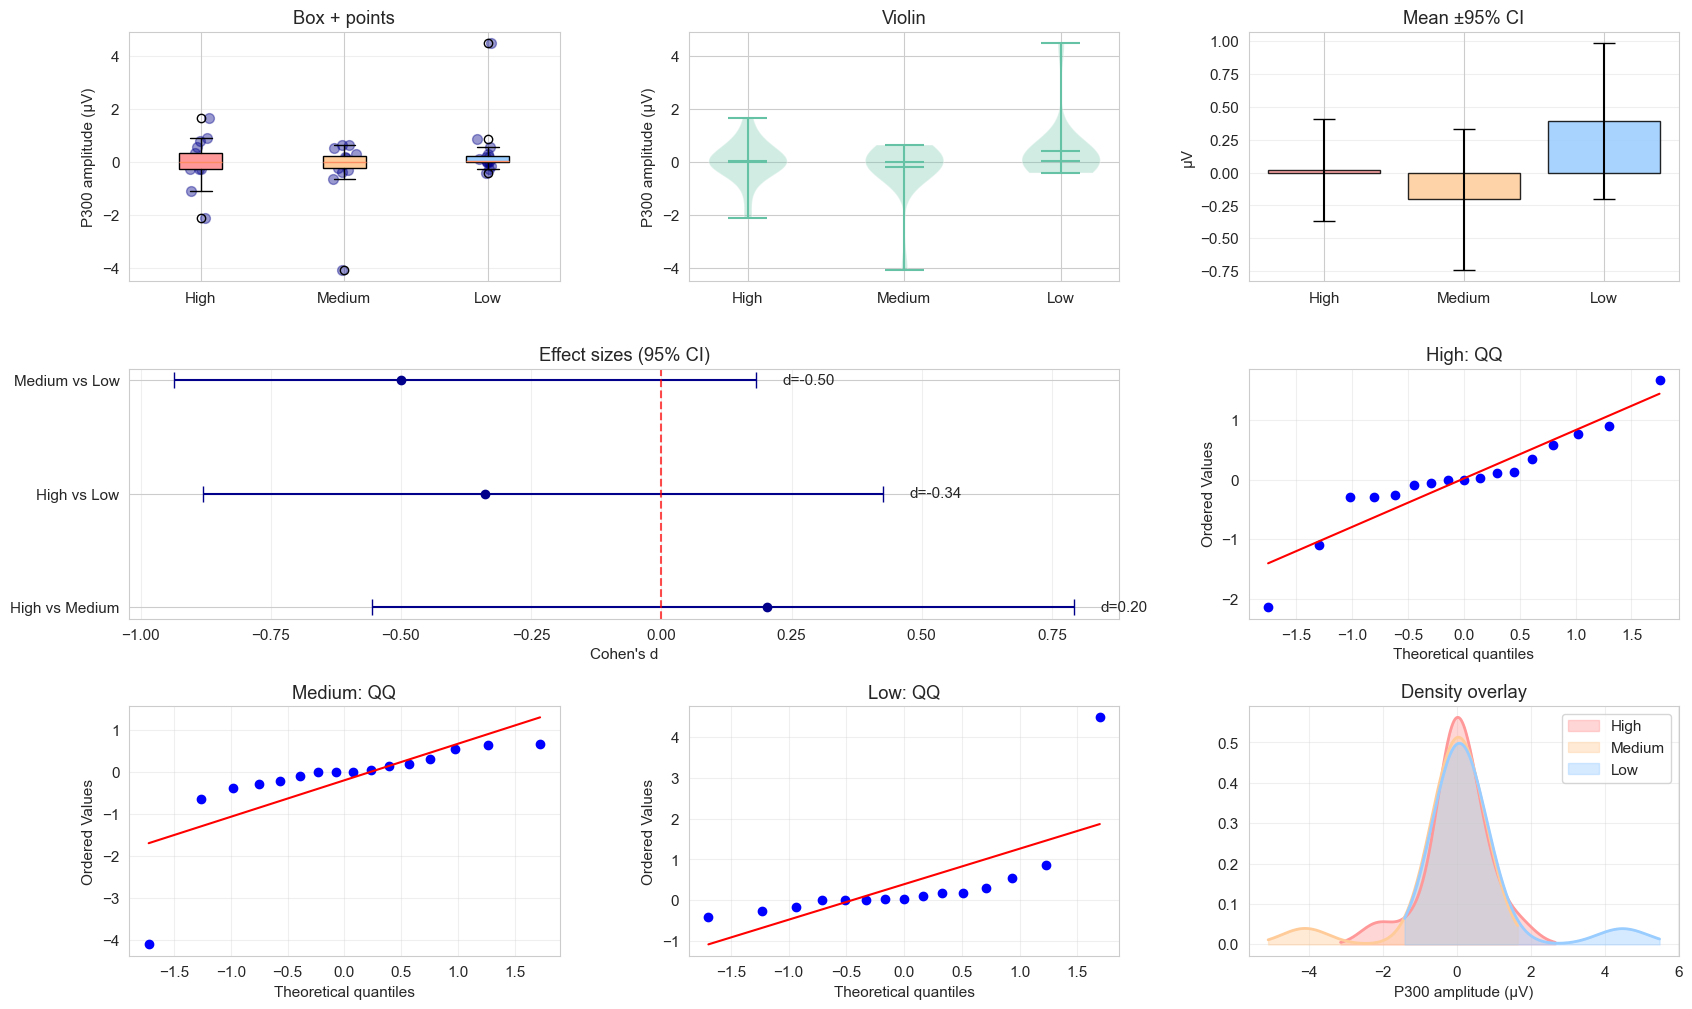

✓ Visualization saved to ./results/lmm_p300_visualizations.png


In [11]:
# Comprehensive visualization
if len(df) == 0:
    print("⚠️  No data available to plot")
else:
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

    data_by_cond = [high_vals, medium_vals, low_vals]
    labels = ['High','Medium','Low']
    colors = ['#ff9999', '#ffcc99', '#99ccff']

    # Box + points
    ax1 = fig.add_subplot(gs[0,0])
    bp = ax1.boxplot(data_by_cond, labels=labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    for i, vals in enumerate(data_by_cond, 1):
        x = np.random.normal(i, 0.04, len(vals))
        ax1.scatter(x, vals, alpha=0.4, s=50, color='darkblue')
    ax1.set_ylabel('P300 amplitude (µV)')
    ax1.set_title('Box + points')
    ax1.grid(True, axis='y', alpha=0.3)

    # Violin
    ax2 = fig.add_subplot(gs[0,1])
    parts = ax2.violinplot(data_by_cond, positions=[1,2,3], showmeans=True, showmedians=True)
    ax2.set_xticks([1,2,3]); ax2.set_xticklabels(labels)
    ax2.set_title('Violin')
    ax2.set_ylabel('P300 amplitude (µV)')


    # Mean ±95% CI
    ax3 = fig.add_subplot(gs[0,2])
    means = [np.mean(v) for v in data_by_cond]
    sems = [np.std(v, ddof=1)/np.sqrt(len(v)) for v in data_by_cond]
    x_pos = np.arange(3)
    ax3.bar(x_pos, means, yerr=1.96*np.array(sems), capsize=8, color=colors, edgecolor='black', alpha=0.85)
    ax3.set_xticks(x_pos); ax3.set_xticklabels(labels)
    ax3.set_title('Mean ±95% CI')
    ax3.set_ylabel('µV')
    ax3.grid(True, axis='y', alpha=0.3)

    # Forest plot
    ax4 = fig.add_subplot(gs[1,:2])
    y_pos = np.arange(len(df_effect_sizes))
    for i, row in df_effect_sizes.iterrows():
        ax4.errorbar(row["Cohen's d"], i, xerr=np.array([[row["Cohen's d"]-row['CI Lower']],[row['CI Upper']-row["Cohen's d"]]]), fmt='o', color='darkblue', capsize=6)
        ax4.text(row['CI Upper']+0.05, i, f"d={row['Cohen\'s d']:.2f}", va='center')
    ax4.axvline(0, color='red', linestyle='--', alpha=0.7)
    ax4.set_yticks(y_pos); ax4.set_yticklabels(df_effect_sizes['Comparison'])
    ax4.set_xlabel("Cohen's d")
    ax4.set_title('Effect sizes (95% CI)')
    ax4.grid(True, axis='x', alpha=0.3)

    # QQ plots
    ax5 = fig.add_subplot(gs[1,2])
    from scipy import stats
    stats.probplot(high_vals, dist='norm', plot=ax5)
    ax5.set_title('High: QQ')
    ax5.grid(True, alpha=0.3)
    ax6 = fig.add_subplot(gs[2,0])
    stats.probplot(medium_vals, dist='norm', plot=ax6)
    ax6.set_title('Medium: QQ')
    ax6.grid(True, alpha=0.3)
    ax7 = fig.add_subplot(gs[2,1])
    stats.probplot(low_vals, dist='norm', plot=ax7)
    ax7.set_title('Low: QQ')
    ax7.grid(True, alpha=0.3)

    # Density overlays
    ax8 = fig.add_subplot(gs[2,2])
    for vals, label, color in zip(data_by_cond, labels, colors):
        if len(vals)==0:
            continue
        kde = gaussian_kde(vals)
        x_range = np.linspace(vals.min()-1, vals.max()+1, 200)
        ax8.fill_between(x_range, kde(x_range), alpha=0.4, label=label, color=color)
        ax8.plot(x_range, kde(x_range), linewidth=2, color=color)
    ax8.set_title('Density overlay')
    ax8.set_xlabel('P300 amplitude (µV)')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    os.makedirs('./results', exist_ok=True)
    plt.tight_layout()
    plt.savefig('./results/lmm_p300_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Visualization saved to ./results/lmm_p300_visualizations.png")

In [12]:
# Results export and textual summary
os.makedirs('./results', exist_ok=True)

df_effect_sizes.to_csv('./results/lmm_p300_effect_sizes.csv', index=False)
df_normality.to_csv('./results/lmm_p300_normality.csv', index=False)

desc_rows = []
for cond in ['High','Medium','Low']:
    vals = df[df['condition']==cond]['amplitude'].values
    desc_rows.append({
        'Condition': cond,
        'N': len(vals),
        'Mean': np.mean(vals) if len(vals)>0 else np.nan,
        'SD': np.std(vals, ddof=1) if len(vals)>1 else np.nan,
        'Median': np.median(vals) if len(vals)>0 else np.nan,
        'Min': np.min(vals) if len(vals)>0 else np.nan,
        'Max': np.max(vals) if len(vals)>0 else np.nan
    })
df_desc = pd.DataFrame(desc_rows)
df_desc.to_csv('./results/lmm_p300_descriptives.csv', index=False)

print("\n" + "="*100)
print("SUMMARY (P300)")
print("="*100)
print(df_desc.to_string(index=False))
print("\nNormality:")
print(df_normality.to_string(index=False))
print(f"\nLevene: F={levene_stat:.4f}, p={levene_p:.4f}")
print(f"Kruskal-Wallis: H={h_stat:.4f}, p={p_kw:.4f}, eps_sq={eps_sq:.4f}")
print("\nEffect sizes:")
print(df_effect_sizes[['Comparison', "Cohen's d", 'CI']].to_string(index=False))
print("\n✓ Exports written to ./results")


SUMMARY (P300)
Condition  N      Mean       SD        Median       Min      Max
     High 17  0.019500 0.817288 -2.678816e-11 -2.139182 1.668320
   Medium 16 -0.204508 1.098389  1.227823e-10 -4.097835 0.650325
      Low 15  0.391693 1.174697  3.841601e-02 -0.407549 4.487141

Normality:
Condition        W  p-value  Normal
     High 0.908272 0.093541    True
   Medium 0.585871 0.000012   False
      Low 0.521387 0.000005   False

Levene: F=0.0017, p=0.9983
Kruskal-Wallis: H=1.0347, p=0.5961, eps_sq=-0.0215

Effect sizes:
    Comparison  Cohen's d              CI
High vs Medium   0.203349 [-0.556, 0.793]
   High vs Low  -0.338950 [-0.879, 0.426]
 Medium vs Low  -0.499799 [-0.936, 0.183]

✓ Exports written to ./results


In [17]:
# Per-component ERP analysis (P300, N400, P600, FRN)
os.makedirs('./results', exist_ok=True)

def effect_size_table(df_comp):
    rows = []
    for a,b in comparisons:
        v1 = df_comp[df_comp['condition']==a]['amplitude'].values
        v2 = df_comp[df_comp['condition']==b]['amplitude'].values
        if len(v1)==0 or len(v2)==0:
            continue
        d, lo, hi = bootstrap_ci(v1, v2, cohens_d, n_boot=3000)
        rows.append({'Comparison': f'{a} vs {b}', "Cohen's d": d, 'CI Lower': lo, 'CI Upper': hi, 'CI': f'[{lo:.3f}, {hi:.3f}]'})
    return pd.DataFrame(rows)

for comp_name in ['P300','N400','P600','FRN']:
    df_comp = df_all[df_all['component']==comp_name].copy()
    if df_comp.empty:
        print(f"⚠️  {comp_name}: no data")
        continue
    print(f"\n{'='*80}\n{comp_name} component\n{'='*80}")
    df_eff = effect_size_table(df_comp)
    print(df_eff[['Comparison', "Cohen's d", 'CI']])

    # Forest plot
    fig, ax = plt.subplots(figsize=(7,4))
    y_pos = np.arange(len(df_eff))
    for i, row in df_eff.iterrows():
        ax.errorbar(row["Cohen's d"], i, xerr=np.array([[row["Cohen's d"]-row['CI Lower']],[row['CI Upper']-row["Cohen's d"]]]), fmt='o', capsize=5, color='navy')
        ax.text(row['CI Upper']+0.05, i, f"d={row['Cohen\'s d']:.2f}", va='center')
    ax.axvline(0, color='red', linestyle='--', alpha=0.7)
    ax.set_yticks(y_pos); ax.set_yticklabels(df_eff['Comparison'])
    ax.set_xlabel("Cohen's d")
    ax.set_title(f"{comp_name}: effect sizes")
    ax.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    forest_path = f"./results/{comp_name.lower()}_lmm_forest.png"
    plt.savefig(forest_path, dpi=300)
    plt.close(fig)
    print(f"✓ Forest saved: {forest_path}")

    # Distribution plots
    fig, axes = plt.subplots(1,3, figsize=(15,4))
    data_by_cond = [
        df_comp[df_comp['condition']=='High']['amplitude'].values,
        df_comp[df_comp['condition']=='Medium']['amplitude'].values,
        df_comp[df_comp['condition']=='Low']['amplitude'].values
    ]
    labels = ['High','Medium','Low']
    axes[0].boxplot(data_by_cond, labels=labels, patch_artist=True)
    for i, vals in enumerate(data_by_cond, 1):
        x = np.random.normal(i, 0.04, len(vals))
        axes[0].scatter(x, vals, alpha=0.4, s=30, color='darkblue')
    axes[0].set_title('Box + points'); axes[0].set_ylabel('Amplitude (µV)'); axes[0].grid(True, axis='y', alpha=0.3)

    axes[1].violinplot(data_by_cond, positions=[1,2,3], showmeans=True, showmedians=True)
    axes[1].set_xticks([1,2,3]); axes[1].set_xticklabels(labels)
    axes[1].set_title('Violin'); axes[1].set_ylabel('Amplitude (µV)'); axes[1].grid(True, axis='y', alpha=0.3)

    colors = ['#ff9999', '#ffcc99', '#99ccff']
    for vals, label, color in zip(data_by_cond, labels, colors):
        if len(vals)==0:
            continue
        kde = gaussian_kde(vals)
        x_range = np.linspace(vals.min()-1, vals.max()+1, 200)
        axes[2].fill_between(x_range, kde(x_range), alpha=0.4, label=label, color=color)
        axes[2].plot(x_range, kde(x_range), linewidth=2, color=color)
    axes[2].set_title('Density'); axes[2].set_xlabel('Amplitude (µV)'); axes[2].set_ylabel('Density'); axes[2].legend(); axes[2].grid(True, alpha=0.3)

    dist_path = f"./results/{comp_name.lower()}_lmm_distributions.png"
    plt.tight_layout()
    plt.savefig(dist_path, dpi=300)
    plt.close(fig)
    print(f"✓ Distributions saved: {dist_path}")


P300 component
       Comparison  Cohen's d               CI
0  High vs Medium   0.204829  [-0.527, 0.801]
1     High vs Low  -0.341483  [-0.860, 0.429]
2   Medium vs Low  -0.506656  [-0.940, 0.149]
✓ Forest saved: ./results/p300_lmm_forest.png
✓ Distributions saved: ./results/p300_lmm_distributions.png

N400 component
       Comparison  Cohen's d               CI
0  High vs Medium   0.210464  [-0.531, 0.793]
1     High vs Low  -0.336226  [-0.884, 0.456]
2   Medium vs Low  -0.502709  [-0.932, 0.167]
✓ Forest saved: ./results/n400_lmm_forest.png
✓ Distributions saved: ./results/n400_lmm_distributions.png

P600 component
       Comparison  Cohen's d               CI
0  High vs Medium   0.001836  [-0.754, 0.708]
1     High vs Low   0.248086  [-0.543, 0.865]
2   Medium vs Low   0.188549  [-0.551, 0.853]
✓ Forest saved: ./results/p600_lmm_forest.png
✓ Distributions saved: ./results/p600_lmm_distributions.png

FRN component
       Comparison  Cohen's d               CI
0  High vs Medium   0

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.



BAYESIAN ESTIMATION (P300 demo)
Bayesian/Pingouin ANOVA skipped: "['ddof1', 'eps'] not in index"


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_group, sigma, cond_offset]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 853 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


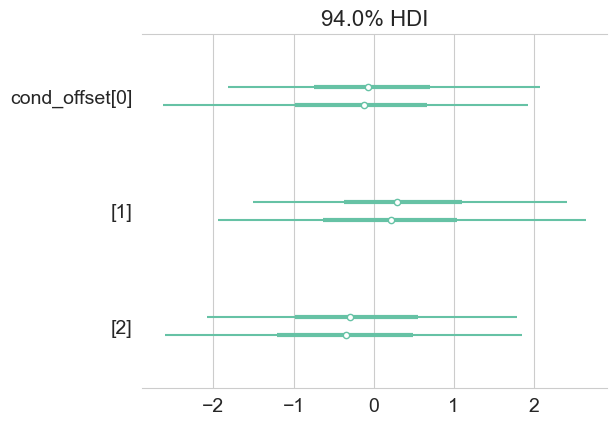

In [18]:
# Optional: Bayesian effect estimation (simple)
if not BAYES_AVAILABLE or not PG_AVAILABLE:
    print("⚠️  Skipping Bayesian section (requires arviz + pingouin)")
else:
    print("\n" + "="*100)
    print("BAYESIAN ESTIMATION (P300 demo)")
    print("="*100)
    # Simple Bayesian ANOVA via pingouin (if available)
    try:
        bf = pg.anova(data=df, dv='amplitude', between='condition', detailed=True)
        print(bf[['Source','ddof1','F','p-unc','np2','eps']])
    except Exception as e:
        print(f"Bayesian/Pingouin ANOVA skipped: {e}")
    
    # Bayesian credible intervals using ArviZ (quick model)
    try:
        import pymc as pm
        cond_codes = pd.Categorical(df['condition']).codes
        with pm.Model() as model:
            mu_group = pm.Normal('mu_group', 0, 10)
            sigma = pm.HalfNormal('sigma', 5)
            cond_offset = pm.Normal('cond_offset', 0, 2, shape=len(np.unique(cond_codes)))
            mu = mu_group + cond_offset[cond_codes]
            obs = pm.Normal('obs', mu, sigma, observed=df['amplitude'].values)
            idata = pm.sample(1000, tune=1000, target_accept=0.9, chains=2, cores=1, progressbar=False)
        az.plot_forest(idata, var_names=['cond_offset']); plt.show()
    except Exception as e:
        print(f"Bayesian model not run: {e}")

In [19]:
# Linear mixed model (participant random intercept) on P300
if len(df) < 5:
    print("⚠️  Not enough data for LMM")
else:
    df_lmm = df.copy()
    df_lmm['condition'] = pd.Categorical(df_lmm['condition'])
    model = smf.mixedlm("amplitude ~ condition", df_lmm, groups=df_lmm['participant'])
    try:
        result = model.fit(reml=False)
        print(result.summary())
    except Exception as e:
        print(f"LMM failed: {e}")

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   amplitude
No. Observations:    48        Method:               ML       
No. Groups:          19        Scale:                1.0010   
Min. group size:     2         Log-Likelihood:       -68.1659 
Max. group size:     3         Converged:            Yes      
Mean group size:     2.5                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.020    0.321  0.062 0.951 -0.609  0.649
condition[T.Low]     0.371    0.568  0.654 0.513 -0.742  1.485
condition[T.Medium] -0.224    0.409 -0.549 0.583 -1.026  0.577
Group Var            0.001    0.836                           

